# Code for the implementation of task MNist

### importing libraries

In [61]:
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import distance
from keras.datasets import mnist
import time

In [62]:
class Dataset:
    def __init__(self, train_X, train_y, test_X, test_y):
        data = {"training": {"targets": [], "features":[]}, "testing": {"targets": [], "features":[]}}
                    
        data["training"]["features"] = train_X
        data["training"]["targets"] = train_y
        data["testing"]["features"] = test_X
        data["testing"]["targets"]  = test_y
        
        self.data = data
        self.DESCR = "MNISK dataset"
        self.n_training = 60000
        self.n_testing = 10000
        self.chunk_size = 1000
        self.n_chunks = self.n_training//self.chunk_size
        self.classes_names = ['0','1','2','3','4','5','6','7','8','9']


In [63]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1] * train_X.shape[2]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1] * test_X.shape[2]))
MNISK_Dataset = Dataset(train_X, train_y, test_X, test_y)


In [64]:
def NN_predict(images_predict, n_chunks, chunk_size, train_set):
    predicted = []
    time_s = time.time()
    for image in images_predict:
        min_dict = {"indices": [], "values": []}
        for i in range(n_chunks):
            reduced_test_set = train_set["features"][i*chunk_size:(i+1)*chunk_size]
            distances = np.ravel(distance.cdist([image], reduced_test_set, 'euclidean'))
            min_cluster_index = np.argmin(distances)
            min_global_index = i*chunk_size+min_cluster_index
            min_dict["indices"].append(min_global_index)
            min_dict["values"].append(distances[min_cluster_index])
        min_dict_NN_index = np.argmin(min_dict["values"])
        NN_global_index = min_dict["indices"][min_dict_NN_index]
        predicted.append(train_set["targets"][NN_global_index])
    print(f"time for Predicting: {time.time()-time_s}")
    return predicted

## Confusion matrix for test set

In [65]:
def PlotConfusionMatrix(matrix, fileName: str):
    fig, ax = plt.subplots(figsize=(8, 8))
    metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, 
                                   display_labels=MNISK_Dataset.classes_names,
                                   ).plot(cmap="YlGnBu", ax=ax)
    plt.title("NN classifier test-set", fontsize=18)
    plt.tight_layout()
    plt.suptitle(f"{fileName}", fontsize=18, x=0.1)
    plt.savefig(f"svg_figures/{fileName}.svg")
    plt.show()

In [66]:
def conf_matrix_test(MNISK_Dataset: Dataset):
    n_classes = 10
    data = MNISK_Dataset.data
    last_index = 500
    conf_matrix = np.zeros((n_classes, n_classes)).astype(int)
    testing_data = data["testing"]["features"][0:last_index]
    prediction = NN_predict(testing_data, MNISK_Dataset.n_chunks, MNISK_Dataset.chunk_size, data["training"])
    n_misclassified = 0
    misclassified_examples = []
    correctly_classified_examples = []
    for i in range(len(prediction)):
        target = data["testing"]["targets"][i]
        pred = prediction[i]
        conf_matrix[target, pred] += 1 
        if target != pred and len(misclassified_examples) < 4:
            n_misclassified += 1
            misclassified_examples.append([testing_data[i], pred, target])
        elif target == pred and len(correctly_classified_examples) < 4:
            correctly_classified_examples.append([testing_data[i], pred, target])


    error_rate = n_misclassified / len(testing_data)
    return conf_matrix, error_rate, misclassified_examples, correctly_classified_examples 

In [67]:
confusion_matrix, error_rate, misclassified_examples, correctly_classified_examples = conf_matrix_test(MNISK_Dataset)

time for Predicting: 0.12351822853088379
time for Predicting: 0.2034313678741455
time for Predicting: 0.30614376068115234
time for Predicting: 0.43619871139526367
time for Predicting: 0.5197293758392334
time for Predicting: 0.5964095592498779
time for Predicting: 0.6834688186645508
time for Predicting: 0.7683501243591309
time for Predicting: 0.8543758392333984
time for Predicting: 0.9394652843475342
time for Predicting: 1.0282227993011475
time for Predicting: 1.1065409183502197
time for Predicting: 1.177173376083374
time for Predicting: 1.2458171844482422
time for Predicting: 1.3258094787597656
time for Predicting: 1.4294171333312988
time for Predicting: 1.5393640995025635
time for Predicting: 1.68855619430542
time for Predicting: 1.9054782390594482
time for Predicting: 2.0412487983703613
time for Predicting: 2.1301612854003906
time for Predicting: 2.2445826530456543
time for Predicting: 2.3149573802948
time for Predicting: 2.4025611877441406
time for Predicting: 2.4796981811523438
tim

Error rate: 0.008


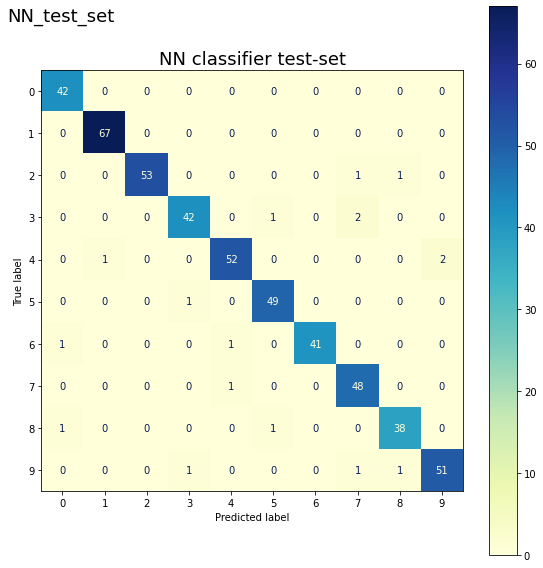

In [68]:
print("Error rate: " + str(error_rate))
PlotConfusionMatrix(confusion_matrix, "NN_test_set")

## 1b) Plot some examples

In [69]:
def PlotExamples(examples, fileName: str):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for i, (image, predicted, target) in enumerate(examples):
        ax = axs[i//2, i%2]
        ax.set_title(f"Classified as {predicted}, target is {target}", fontsize=18)
        ax.imshow(np.reshape(image, (28, 28)), cmap='YlGnBu')

    fig.subplots_adjust(hspace=0.4)
    plt.savefig(f"svg_figures/{fileName}.svg")
    plt.show()

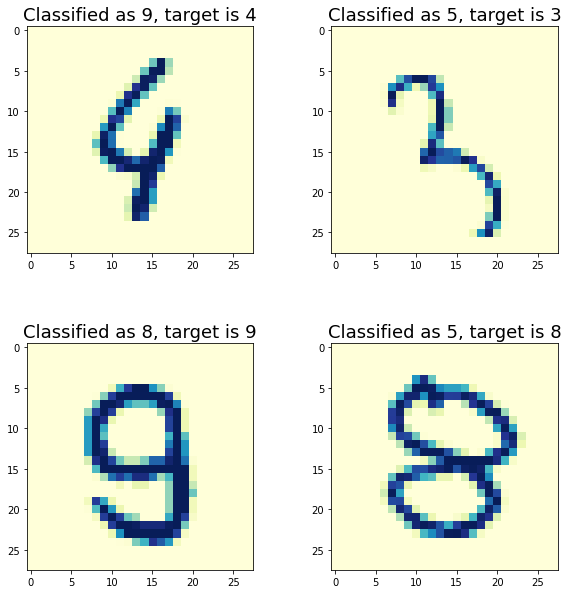

In [70]:
PlotExamples(misclassified_examples, "misclassified")


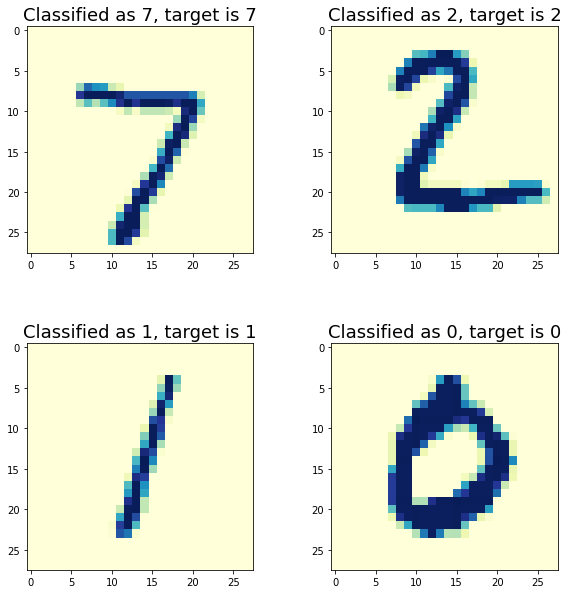

In [71]:
PlotExamples(correctly_classified_examples, "Correctly_classified")

There is not too much to say about the correctly classified examples. They all seem to be pretty easy to handle for the classifier. As for the misclassified examples, there were some somewhat strange results. As humans, it is hard to understand why the image with the number eight was classified as a five, although one can see the contour of parts of a five if one uses ones imagination. It is also a little bit hard to see how the image with the number three can be classified as a five, but also here it is possible to see how the classifier got it wrong. One can see something resembling the lower part of a five, and it is not a very pretty number three. The two other misclassification examples makes more sense in our opinion, even though it is easy for us as humans to see what they should be.  

In [87]:
def CreateClusters(n_clusters, train_x, train_y):
    time_s = time.time()
    # sorting the data
    n_classes = 10
    tuples = [(train_x[i], train_y[i]) for i in range(len(train_x))]
    tuples = sorted(tuples, key=lambda x: x[1])
    train_x = np.array([t[0] for t in tuples])
    train_y = np.array([t[1] for t in tuples])
    # flatten
    train_x = train_x.flatten().reshape(train_x.shape)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    break_points = [0]
    for i in range(len(train_y)-1):
        if train_y[i] != train_y[i+1]:
            break_points.append(i+1)
    # kmeans.fit(train_x)
    break_points.append(len(train_x)-1)
    
    clusters = np.empty((n_classes, n_clusters, train_x.shape[1]))
    for i in range(n_classes):
        clusters[i] = kmeans.fit(train_x[break_points[i]:break_points[i+1]]).cluster_centers_
    
    clusters = clusters.flatten().reshape(n_classes*n_clusters, train_x.shape[1])
    print(f"time for Clustering: {time.time()-time_s}")
    return clusters

In [86]:
def cnn_test(clusters, test_x, test_y):
    n_classes = 10
    test_x = test_x.flatten().reshape(test_x.shape)
    conf_matrix = np.zeros((n_classes, n_classes)).astype(int)
    errors = 0
    time_s2 = time.time()
    for index, img in enumerate(test_x):
        distances = []
        for cluster in clusters:
             distances.append(distance.euclidean(img, cluster))
        pred = np.argmin(distances) // 64
        conf_matrix[test_y[index], pred] += 1
        if pred != test_y[index]:
            errors += 1
    print(f"time for Predicting: {time.time()-time_s2}")
    print("Error rate: " + str(errors/len(test_y)))
    PlotConfusionMatrix(conf_matrix, "cNN_test_set")    
    
        
    

In [88]:
last_index = 2000
clusters = CreateClusters(64, MNISK_Dataset.data["training"]["features"][:last_index], MNISK_Dataset.data["training"]["targets"][:last_index])    

/home/simon/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/simon/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/simon/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/simon/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/simon/.local/lib/python3.10/si

time for Clustering: 13.246412515640259


time for Predicting: 18.089765310287476
Error rate: 0.131


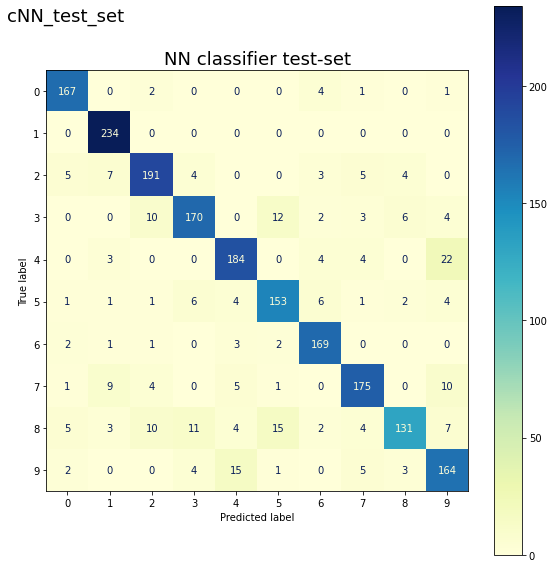

In [89]:
cnn_test(clusters, MNISK_Dataset.data["testing"]["features"][:last_index], MNISK_Dataset.data["testing"]["targets"][:last_index])

In [79]:
def cknn_test(clusters, k, test_x, test_y):
    n_classes = 10
    test_x = test_x.flatten().reshape(test_x.shape)
    conf_matrix = np.zeros((n_classes, n_classes)).astype(int)
    errors = 0
    time_s2 = time.time()
    for index, img in enumerate(test_x):
        distances = []
        for cluster in clusters:
             distances.append(distance.euclidean(img, cluster))
    
        top_k = np.argsort(distances)[:k]
        votes = [0] * n_classes
        for val in top_k:
            votes[(val // 64)] += 1
        pred = np.argmin(votes)
        conf_matrix[test_y[index], pred] += 1
        if pred != test_y[index]:
            errors += 1
    print(f"time for Predicting: {time.time()-time_s2}")
    print("Error rate: " + str(errors/len(test_y)))
    PlotConfusionMatrix(conf_matrix, "cKNN_test_set")    

time for Predicting: 18.300682544708252
Error rate: 1.0


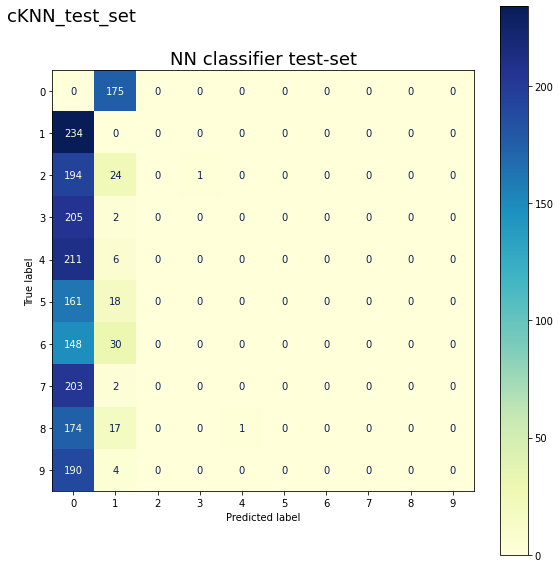

In [83]:
cknn_test(clusters, 7, MNISK_Dataset.data["testing"]["features"][:last_index], MNISK_Dataset.data["testing"]["targets"][:last_index])